In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

In [2]:
random.seed(10)

# Modelado basado en Agentes

El [modelado basado en agentes (ABM)](http://en.wikipedia.org/wiki/Agent-based_model) surge en la década de los 70s. Se caracteriza por la aparición de un _ente_, llamado **agente** que cumple con las siguientes características:

- Los agentes modelan comportamiento inteligente, usualmente mediante un conjunto simple de reglas.

- Los agentes están localizados en el espacio (_Mundo_) e interactúan con otros agentes (sus _vecinos_) localmente.

- Debido a esto, los agentes tienen información imperfecta y local.

- Elemento azarosos en los agentes o en el mundo.

Las características mencionadas los hace ideales para:

- Estudiar la dinámica de sistemas que no están en equilibrio.

- Entender la aparición de **macrocomportamiento** a partir de _motivos individuales_.

In [3]:
class Agente:
    """ Agente general """
    def __init__(self, tipo, locacion=np.array([0,0])):
        self.tipo = tipo
        self.locacion = locacion
        self.siguiente_accion = None

    def distancia(self, otro):
        "Calcula la distancia euclídea entre este agente y otro."
        return np.linalg.norm(self.locacion - otro.locacion)  # Otra manera es usar np.sqrt(np.sum((a-b)**2))
    
    def vecinos(self, agentes):
        pass
    
    def actuar(self, agentes):
        self.locacion =  self.siguiente_accion
        
    def decidir(self, agentes):
        self.siguiente_accion = np.array([random.uniform(0, 1), random.uniform(0, 1)]) # Toma una nueva posición al azar
    
    def actualizar(self, agentes):
        self.decidir(agentes)
        self.actuar(agentes)

In [4]:
class Mundo:
    def __init__(self, agentes, ancho=8, alto=8, steps = 10):
        self.agentes = agentes
        self.ancho = ancho
        self.alto = alto
        self.steps = steps
        self.init_anim()
        
        print ("Creado el mundo")
        
    def init_anim(self):
        self.fig = plt.figure(figsize=(self.ancho, self.alto))
        self.ax = plt.axes(xlim=(0, 1), ylim=(0, 1))
        plot_args = {'markersize' : 8, 'alpha' : 0.6}
        self.puntos, = self.ax.plot([], [], 'o', **plot_args)
       
       
    def dibujar(self, step):
        x_values_0, y_values_0 = [], []
        for agente in self.agentes:
            x, y = agente.locacion
            x_values_0.append(x)
            y_values_0.append(y)

        self.puntos.set_data(x_values_0, y_values_0)
        
        self.ax.set_title('Paso {}'.format(step))
        
        return self.puntos,
       
    def actualizar(self, step):   
        self.dibujar(step) # Dibuja el mundo
        
        for agente in self.agentes:
            agente.actualizar(self.agentes)
    
    def clean_screen(self):
        self.puntos.set_data([], [])
        return self.puntos,
          
    def simular(self):
        anim = animation.FuncAnimation(self.fig, self.actualizar, init_func=self.clean_screen, frames=self.steps, interval=1000, blit=False)
        return anim


Creado el mundo


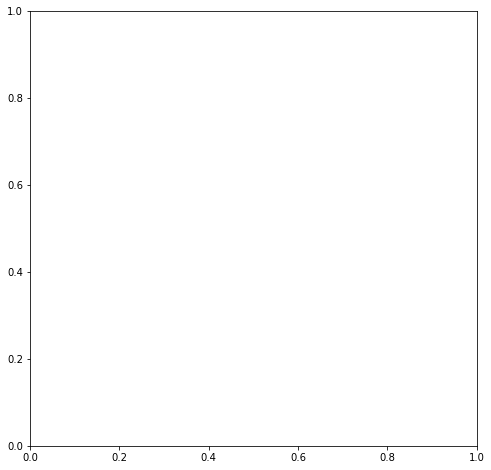

In [5]:
num_agentes = 10

agentes_simples = [Agente(tipo=0) for i in range(num_agentes)]


sin_chiste = Mundo(agentes = agentes_simples, steps = 10)


simulacion = sin_chiste.simular()

In [6]:
HTML(simulacion.to_html5_video())

<div class="alert alert-info">
    
**Ejercicio** Crea una clase que herede de `Agente` de tal manera que sea un _borracho_, i.e. que se mueva siguiendo una **caminata aleatoria**. Luego ejecuta la simulación con 10 borrachos.

</div>

In [7]:
class Borracho(Agente):
    
    def __init__(self, delta=0.1):
        Agente.__init__(self, tipo="borracho")
        self.delta = delta # Tamaño de paso en x y y
        self.posibles_direcciones = (0,1) #  (quieto, avanzar uno)
        
    def actuar(self, agentes):
        self.locacion = self.locacion + self.siguiente_accion*self.delta # moverme
        
        if (self.locacion >= np.ones(2)-0.01).all():
            self.locacion = np.ones(2)-0.01 # Si llegamos al límite superior derecho nos detenemos    
        
    def decision(self, agentes):
        self.siguiente_accion = np.array([random.choice(self.posibles_direcciones), random.choice(self.posibles_direcciones)]) 
        # Elegir una direccion entre quedarme quieto o moverme hacia adelante
        
    def actualizar(self, agentes):
        self.decision(agentes)
        self.actuar(agentes)

Creado el mundo


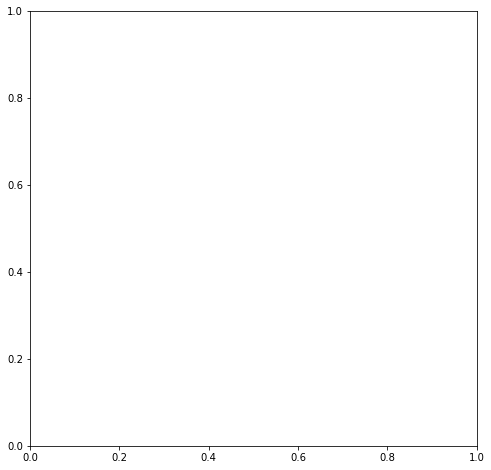

In [8]:
num_borrachos = 10

borrachos = [Borracho(delta=0.01) for i in range(num_borrachos)]


condesa = Mundo(agentes = borrachos, steps = 250)


simulacion = condesa.simular()

In [9]:
HTML(simulacion.to_html5_video())

## Ejemplo: Modelo de segregación racial de Thomas Schelling

En 1971, **Thomas Schelling** publicó [_Dynamic Models of Segregation_](http://www.stat.berkeley.edu/~aldous/157/Papers/Schelling_Seg_Models.pdf) en el cual se proponía un modelo muy simple de segregación racial.

En el modelo de Schelling, el mundo es una rejilla rectangular y cada celda representa una casa. La casa pueden estar ocupadas por dos tipos de "agentes", etiquetados como _rojo_ y _azul_, en números aproximadamente iguales. Cerca del 10% de las casas están vacías.

Para cada instante $t$, un agente puede estar **contento** o **infeliz**, dependiendo de los otros agentes de la vecindad, la vecindad está compuesta por las 8 celdas adyacentes al agente en cuestión. 

La simulación procede como sigue: Se elige un agente al azar y se verifica su estado para ver si está feliz, si lo está, nada pasa, si no, el agente decide cambiarse a una celda desocupada al azar y se muda.

Rapidamente un patrón va a aparecer.

<div class="alert alert-info">
    
**Ejercicio:** ¿Te imaginas que patrón va a aparecer?
</div>

La implementación que sigue es una versión simplificada del modelo de segregación de Schelling.

In [10]:
class AgenteSchelling(Agente):
    
    def __init__(self, tipo, homofilia=5, vecinos=7):
        Agente.__init__(self, tipo)
        self.homofilia = homofilia
        self.vecinos = vecinos # Quienes son mis vecinos
        self.feliz = False
        self.locacion = np.array([random.uniform(0, 1), random.uniform(0, 1)]) # Posición al azar inicial
        
    def actuar(self, agentes):
        self.locacion = np.array([random.uniform(0, 1), random.uniform(0, 1)]) # Brinco a una nueva posición
        
    def decision(self, agentes):
        """Verdadero si un número suficiente de vecinos cercanos es del mismo tipo."""
        distancias = []
        # Distancias es una lista de pares (distancia, agente)
        for agente in agentes:
            if self != agente:
                distancia = self.distancia(agente)
                distancias.append((distancia, agente))
        # Ordenamos del más cercano al más lejano 
        distancias.sort()
        vecinos = [agente for dist, agente in distancias[:self.vecinos]]
        # Contamos cuantos vecinos son del mismo tipo 
        num_mismo_tipo = sum(self.tipo == agente.tipo for agente in vecinos)
        
        self.feliz = (num_mismo_tipo >= self.homofilia)
        
        return self.feliz

    def actualizar(self, agentes):
        """Si no está feliz, escoge una posición nueva al azar, sólo se detiene cuando está feliz."""
        self.decision(agentes)
        if not self.feliz:
            self.actuar(agentes) # No estaba feliz en la ultima ronda
            

            

In [14]:
class MundoSchelling(Mundo):

    def init_anim(self):
        self.fig = plt.figure(figsize=(self.ancho, self.alto))
        self.ax = plt.axes(xlim=(0, 1), ylim=(0, 1))
        plot_args = {'markersize' : 8, 'alpha' : 0.6}
        self.puntos_0, = self.ax.plot([], [], 'o', markerfacecolor='blue', **plot_args)
        self.puntos_1, = self.ax.plot([], [], 'o', markerfacecolor='green', **plot_args)
    
    def clean_screen(self):
        self.puntos_0.set_data([], [])
        self.puntos_1.set_data([], [])
        return 
    
    def dibujar(self,step):
   
        x_values_0, y_values_0 = [], []
        x_values_1, y_values_1 = [], []
    
        for agente in self.agentes:
            x, y = agente.locacion
            if agente.tipo == 0:
                x_values_0.append(x)
                y_values_0.append(y)
            else:
                x_values_1.append(x)
                y_values_1.append(y)

                
        self.puntos_0.set_data(x_values_0, y_values_0)
        self.puntos_1.set_data(x_values_1, y_values_1)
        
        self.ax.set_title('Paso {}'.format(step))

        return 

Creado el mundo


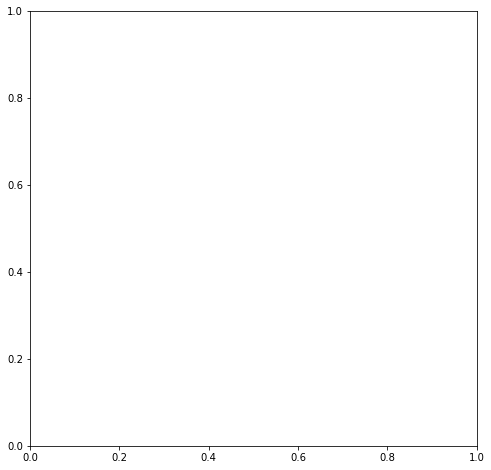

In [15]:
num_tipo_0 = 200
num_tipo_1 = 200

agentes = [AgenteSchelling(tipo=0) for i in range(num_tipo_0)]
agentes.extend(AgenteSchelling(tipo=1) for i in range(num_tipo_1))


schelling_world = MundoSchelling(agentes = agentes, steps = 30)

simu_schelling = schelling_world.simular()

In [16]:
HTML(simu_schelling.to_html5_video())

El modelo de Schelling fué uno de los primeros modelos basados en agentes. Desde entonces, el modelado basado en agentes es una herramienta importante en las ciencias sociales y en algunas ciencias naturales.

<div class="alert alert-info">
    
**Ejercicio** Modifica el código de `MundoSchelling` para que cuentes el número de agentes que se mueven en cada paso.
</div>

In [ ]:
class AgenteSchelling(Agente):
    
    def __init__(self, tipo, homofilia=5, vecinos=7):
        Agente.__init__(self, tipo)
        self.homofilia = homofilia
        self.vecinos = vecinos # Quienes son mis vecinos
        self.feliz = False
        self.locacion = np.array([random.uniform(0, 1), random.uniform(0, 1)]) # Posición al azar inicial
        
    def actuar(self, agentes):
        self.locacion = np.array([random.uniform(0, 1), random.uniform(0, 1)]) # Brinco a una nueva posición
        
    def decision(self, agentes):
        """Verdadero si un número suficiente de vecinos cercanos es del mismo tipo."""
        distancias = []
        # Distancias es una lista de pares (distancia, agente)
        for agente in agentes:
            if self != agente:
                distancia = self.distancia(agente)
                distancias.append((distancia, agente))
        # Ordenamos del más cercano al más lejano 
        distancias.sort()
        vecinos = [agente for dist, agente in distancias[:self.vecinos]]
        # Contamos cuantos vecinos son del mismo tipo 
        num_mismo_tipo = sum(self.tipo == agente.tipo for agente in vecinos)
        
        self.feliz = (num_mismo_tipo >= self.homofilia)
        
        return self.feliz

    def actualizar(self, agentes):
        """Si no está feliz, escoge una posición nueva al azar, sólo se detiene cuando está feliz."""
        self.decision(agentes)
        if not self.feliz:
            self.actuar(agentes) # No estaba feliz en la ultima ronda
            

            

In [18]:
class MundoSchelling(Mundo):

    def init_anim(self):
        self.fig = plt.figure(figsize=(self.ancho, self.alto))
        self.ax = plt.axes(xlim=(0, 1), ylim=(0, 1))
        plot_args = {'markersize' : 8, 'alpha' : 0.6}
        self.puntos_0, = self.ax.plot([], [], 'o', markerfacecolor='blue', **plot_args)
        self.puntos_1, = self.ax.plot([], [], 'o', markerfacecolor='green', **plot_args)
    
    def clean_screen(self):
        self.puntos_0.set_data([], [])
        self.puntos_1.set_data([], [])
        return 
    #intento de hacer el ejercicio 
    def estadistica(self, step):
        cuenta = 0
        for agente in self.agentes:
            if agente.feliz == False:
                cuenta += 1
        return cuenta
    def dibujar(self,step):
   
        x_values_0, y_values_0 = [], []
        x_values_1, y_values_1 = [], []
    
        for agente in self.agentes:
            x, y = agente.locacion
            if agente.tipo == 0:
                x_values_0.append(x)
                y_values_0.append(y)
            else:
                x_values_1.append(x)
                y_values_1.append(y)

                
        self.puntos_0.set_data(x_values_0, y_values_0)
        self.puntos_1.set_data(x_values_1, y_values_1)
        
        self.ax.set_title('Paso {}'.format(step))

        return 

Creado el mundo


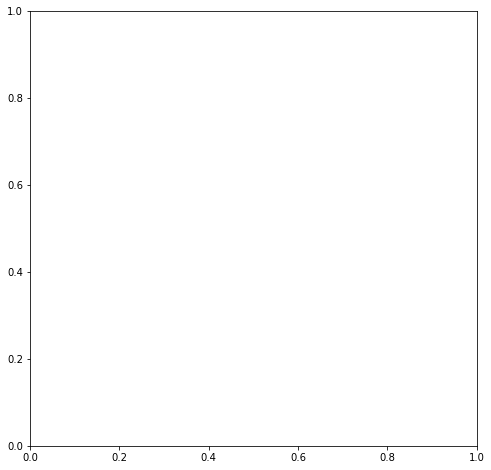

In [19]:
num_tipo_0 = 200
num_tipo_1 = 200

agentes = [AgenteSchelling(tipo=0) for i in range(num_tipo_0)]
agentes.extend(AgenteSchelling(tipo=1) for i in range(num_tipo_1))


schelling_world = MundoSchelling(agentes = agentes, steps = 30)

simu_schelling = schelling_world.simular()

<div class="alert alert-info">
    
**Ejercicio** Modifica el código de `MundoSchelling` para agregar un método llamado `estadistica` que muestre en una gráfica el número de agentes que se mueven en función de los `steps`.
</div>

<div class="alert alert-info">
    
**Ejercicio** ¿Cómo modelas que se vuelvan más tolerantes? ¿Qué esperas que pase? ¿Qué pasa si los agentes se vuelven más tolerantes con el método `estadistica`?
</div>

<div class="alert alert-info">
    
**Ejercicio** ¿Cómo modelas que el agente sólo esté feliz en ambientes mixtos, i.e. si se vuelve infeliz si muchos vecinos son como él? 
</div>